In [1]:
# Running the full assignment pipeline for Polynomial Regression as requested.
# This code will:
#  - Load the CSV at /mnt/data/polynomial_regression.csv
#  - Perform 80:20 split into train/test
#  - PART 1: create 30 samples of size 20 from train, fit polynomials degree 1..10 on each sample,
#            record train and test MSE, create violin plots for test error vs degree and for (train-test)
#  - PART 2: draw one sample of 20 points from train, use 5-fold CV to select best degree (1..10),
#            train on that sample and evaluate on test set
#  - PART 3: on full train, use 10-fold CV with L1 (Lasso) and L2 (Ridge) regularization across degrees 1..10
#            and a grid of alphas. Report best models and test MSE.
# Notes:
#  - Error metric = Mean Squared Error (MSE)
#  - Random seeds fixed for reproducibility
#  - Uses matplotlib (no seaborn) for plots as requested

In [2]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score


In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [ ]:
# ---------- Helper functions ----------
def load_data(path="data.csv"):
    df = pd.read_csv(path)
    if {'x', 'y'}.issubset(df.columns):
        return df[['x', 'y']].rename(columns={'x':'x','y':'y'})
    # fallback: assume first two columns are x and y
    cols = df.columns.tolist()
    return df[[cols[0], cols[1]]].rename(columns={cols[0]:'x', cols[1]:'y'})


In [5]:
def make_pipeline(degree, model):
    # Pipeline: PolynomialFeatures -> StandardScaler -> model
    return Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('scaler', StandardScaler()),
        ('model', model)
    ])

In [8]:
# ---------- Load and split ----------
data = load_data("polynomial_regression.csv")
X = data[['x']].values
y = data['y'].values

# 80:20 split (train / test) - note: user instruction mandates using train for sampling in parts 1 & 2
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

print(f"Full dataset size: {len(X)}; Train size: {len(X_train_full)}; Test size: {len(X_test)}")


Full dataset size: 10000; Train size: 8000; Test size: 2000


In [9]:
# ------------------------------
# Part 1: 30 samples (size 20 each) from TRAIN; for each sample, fit degrees 1..10
# Measure train R2 (on the 20 points) and test R2 (on full test set)
# Produce violin plots: degree vs test R2 and degree vs (train R2 - test R2)
# ------------------------------
n_samples = 30
sample_size = 20
max_degree = 10

# storage: dict degree -> list of R2 across samples
part1_train_r2 = {d: [] for d in range(1, max_degree+1)}
part1_test_r2  = {d: [] for d in range(1, max_degree+1)}

for s in range(n_samples):
    # sample 20 points WITHOUT replacement from the training set
    idx = np.random.choice(range(len(X_train_full)), size=sample_size, replace=False)
    X_sample = X_train_full[idx]
    y_sample = y_train_full[idx]

    for deg in range(1, max_degree+1):
        model = make_pipeline(deg, LinearRegression())
        # fit on this 20-point sample
        model.fit(X_sample, y_sample)
        # train R2 computed on the same 20 points (as assignment requested)
        y_train_pred = model.predict(X_sample)
        train_r2 = r2_score(y_sample, y_train_pred)
        part1_train_r2[deg].append(train_r2)

        # test R2 computed on the full held-out test set
        y_test_pred = model.predict(X_test)
        test_r2 = r2_score(y_test, y_test_pred)
        part1_test_r2[deg].append(test_r2)


In [10]:
# Convert to arrays for plotting convenience
train_r2_arrays = [np.array(part1_train_r2[d]) for d in range(1, max_degree+1)]
test_r2_arrays  = [np.array(part1_test_r2[d])  for d in range(1, max_degree+1)]
r2_diff_arrays  = [train_r2_arrays[i] - test_r2_arrays[i] for i in range(max_degree)]

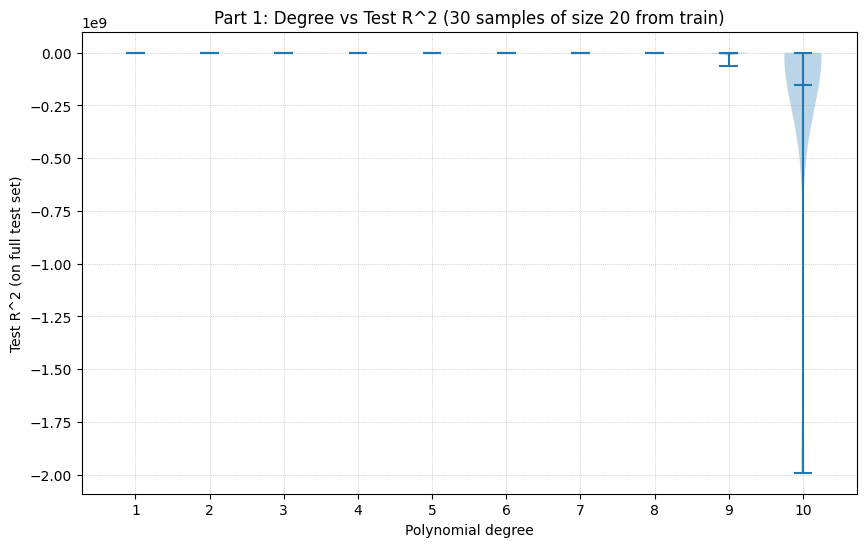

In [26]:
# ---------- Plots for Part 1 ----------
degrees = list(range(1, max_degree+1))

# Violin plot: degree vs test R2
plt.figure(figsize=(10, 6))
plt.violinplot(test_r2_arrays, positions=degrees, showmeans=True)
plt.xlabel("Polynomial degree")
plt.xticks(degrees)
plt.ylabel("Test R^2 (on full test set)")
plt.title("Part 1: Degree vs Test R^2 (30 samples of size 20 from train)")
plt.grid(True, linestyle=':', linewidth=0.5)
plt.savefig("part1_degree_vs_testR2_violin.png", dpi=200, bbox_inches='tight')
# plt.close()

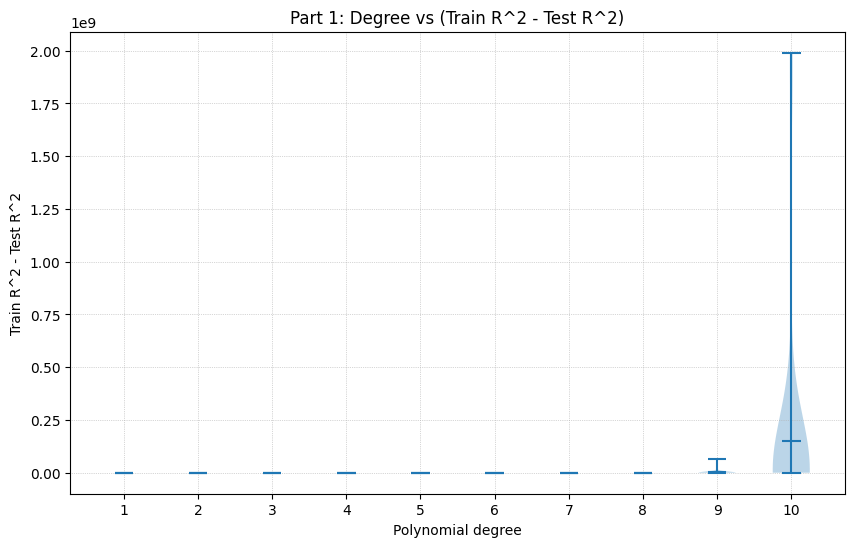

In [27]:
# Violin plot: degree vs (train R2 - test R2)
plt.figure(figsize=(10, 6))
plt.violinplot(r2_diff_arrays, positions=degrees, showmeans=True)
plt.xlabel("Polynomial degree")
plt.xticks(degrees)
plt.ylabel("Train R^2 - Test R^2")
plt.title("Part 1: Degree vs (Train R^2 - Test R^2)")
plt.grid(True, linestyle=':', linewidth=0.5)
plt.savefig("part1_degree_vs_train_minus_test_r2_violin.png", dpi=200, bbox_inches='tight')
# plt.close()


In [13]:
print("Part 1 complete. Plots saved: part1_degree_vs_testR2_violin.png and part1_degree_vs_train_minus_test_r2_violin.png")


Part 1 complete. Plots saved: part1_degree_vs_testR2_violin.png and part1_degree_vs_train_minus_test_r2_violin.png


In [14]:
# ------------------------------
# Part 2:
# - From TRAIN, sample 20 points
# - Use k=5 fold CV on that 20-point sample to determine best degree (1..10)
# - Train model of that degree on the 20 points and evaluate on test set
# ------------------------------
k = 5
# sample one set of 20 points from train (fresh sample)
idx = np.random.choice(range(len(X_train_full)), size=sample_size, replace=False)
X_sample2 = X_train_full[idx]
y_sample2 = y_train_full[idx]

cv = KFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)

degree_scores = {}
for deg in range(1, max_degree+1):
    pipe = make_pipeline(deg, LinearRegression())
    # use cross_val_score with scoring='r2'
    scores = cross_val_score(pipe, X_sample2, y_sample2, cv=cv, scoring='r2')
    degree_scores[deg] = np.mean(scores)

best_degree = max(degree_scores.items(), key=lambda kv: (kv[1], -kv[0]))[0]  # max mean R2; tie-break to lower deg by -deg in key
print(f"Part 2: CV mean R2 per degree (on 20-sample):")
for d in range(1, max_degree+1):
    print(f"  Degree {d}: mean CV R2 = {degree_scores[d]:.4f}")
print(f"Selected best degree (Part 2) = {best_degree}")


Part 2: CV mean R2 per degree (on 20-sample):
  Degree 1: mean CV R2 = 0.7776
  Degree 2: mean CV R2 = 0.7117
  Degree 3: mean CV R2 = 0.9133
  Degree 4: mean CV R2 = 0.9688
  Degree 5: mean CV R2 = 0.9071
  Degree 6: mean CV R2 = 0.9033
  Degree 7: mean CV R2 = -4.0767
  Degree 8: mean CV R2 = -4.3871
  Degree 9: mean CV R2 = -9466.5541
  Degree 10: mean CV R2 = -78917.8589
Selected best degree (Part 2) = 4


In [15]:
# Train on the same 20-sample and evaluate on the test set
model_part2 = make_pipeline(best_degree, LinearRegression())
model_part2.fit(X_sample2, y_sample2)
y_test_pred_part2 = model_part2.predict(X_test)
part2_test_r2 = r2_score(y_test, y_test_pred_part2)
print(f"Part 2: Test R^2 (final model trained on 20-sample, degree {best_degree}) = {part2_test_r2:.4f}")


Part 2: Test R^2 (final model trained on 20-sample, degree 4) = 0.2372


In [16]:
# Save a small diagnostics plot: true vs predicted on test
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred_part2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--')
plt.xlabel("y_true (test)")
plt.ylabel("y_pred (test)")
plt.title(f"Part 2: Degree {best_degree} model — Test set predictions (R^2={part2_test_r2:.4f})")
plt.grid(True, linestyle=':')
plt.savefig("part2_test_true_vs_pred.png", dpi=200, bbox_inches='tight')
plt.close()

In [17]:
# ------------------------------
# Part 3:
# - On full TRAIN (not using previous selected degrees), use k=10 fold CV and L1/L2 regularisation
# - Fit polynomial and measure accuracy on test data
# - We'll treat this as a fresh problem: search degrees 1..10 and alpha over a grid for Ridge (L2) and Lasso (L1)
# ------------------------------
degrees_to_try = list(range(1, 11))  # fresh search
alpha_grid = np.logspace(-4, 3, 8)    # regularization strengths to try

cv3 = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

best_config = None
best_cv_score = -np.inf

# Search over degree and regularizer type/alpha
for deg in degrees_to_try:
    # Ridge
    for alpha in alpha_grid:
        pipe = make_pipeline(deg, Ridge(alpha=alpha, random_state=RANDOM_STATE, max_iter=10000))
        scores = cross_val_score(pipe, X_train_full, y_train_full, cv=cv3, scoring='r2')
        mean_score = np.mean(scores)
        if mean_score > best_cv_score:
            best_cv_score = mean_score
            best_config = ('Ridge', deg, alpha)

    # Lasso
    for alpha in alpha_grid:
        # Lasso sometimes needs higher max_iter and may converge slowly on high-degree features
        pipe = make_pipeline(deg, Lasso(alpha=alpha, random_state=RANDOM_STATE, max_iter=20000))
        scores = cross_val_score(pipe, X_train_full, y_train_full, cv=cv3, scoring='r2')
        mean_score = np.mean(scores)
        if mean_score > best_cv_score:
            best_cv_score = mean_score
            best_config = ('Lasso', deg, alpha)


c:\Users\ACER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.135e+07, tolerance: 2.052e+06
  model = cd_fast.enet_coordinate_descent(
c:\Users\ACER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.026e+07, tolerance: 1.989e+06
  model = cd_fast.enet_coordinate_descent(
c:\Users\ACER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

In [20]:
# Also try plain LinearRegression as baseline (no regularization)
for deg in degrees_to_try:
    pipe = make_pipeline(deg, LinearRegression())
    scores = cross_val_score(pipe, X_train_full, y_train_full, cv=cv3, scoring='r2')
    mean_score = np.mean(scores)
    if mean_score > best_cv_score:
        best_cv_score = mean_score
        best_config = ('Linear', deg, None)
        
print(f"Part 3: Best config found by CV: {best_config} with CV mean R2 = {best_cv_score:.4f}")

Part 3: Best config found by CV: ('Linear', 5, None) with CV mean R2 = 0.9964


In [21]:
# Retrain the best model on full train and evaluate on the test set
best_type, best_deg, best_alpha = best_config
if best_type == 'Ridge':
    final_model = make_pipeline(best_deg, Ridge(alpha=best_alpha, random_state=RANDOM_STATE, max_iter=10000))
elif best_type == 'Lasso':
    final_model = make_pipeline(best_deg, Lasso(alpha=best_alpha, random_state=RANDOM_STATE, max_iter=20000))
else:
    final_model = make_pipeline(best_deg, LinearRegression())

final_model.fit(X_train_full, y_train_full)
y_test_pred_part3 = final_model.predict(X_test)
part3_test_r2 = r2_score(y_test, y_test_pred_part3)
print(f"Part 3: Final chosen model ({best_type}, degree={best_deg}, alpha={best_alpha}) -> Test R^2 = {part3_test_r2:.4f}")


Part 3: Final chosen model (Linear, degree=5, alpha=None) -> Test R^2 = 0.9965


In [22]:
# Save diagnostic plot for part3
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred_part3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--')
plt.xlabel("y_true (test)")
plt.ylabel("y_pred (test)")
plt.title(f"Part 3: {best_type} deg={best_deg} — Test preds (R^2={part3_test_r2:.4f})")
plt.grid(True, linestyle=':')
plt.savefig("part3_test_true_vs_pred.png", dpi=200, bbox_inches='tight')
plt.close()

In [23]:

print("All parts complete. Key outputs:")
print(f"  Part2 test R^2 = {part2_test_r2:.4f} (degree {best_degree})")
print(f"  Part3 test R^2 = {part3_test_r2:.4f} (best config {best_config})")
print("Saved plots: part1_* (two violins), part2_test_true_vs_pred.png, part3_test_true_vs_pred.png")

All parts complete. Key outputs:
  Part2 test R^2 = 0.2372 (degree 4)
  Part3 test R^2 = 0.9965 (best config ('Linear', 5, None))
Saved plots: part1_* (two violins), part2_test_true_vs_pred.png, part3_test_true_vs_pred.png
